In [2]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

$$ \beta\,(u-v) - \frac{d}{dx}\left(m_u\frac{du}{dx}\right) = f_1\qquad x\in\,(0,L)$$
$$ \beta\,(v-u) - \frac{d}{dx}\left(m_v\frac{dv}{dx}\right) = f_2\qquad x\in\,(0,L)$$

cond(Z) = 607.9833172150023
monolithic error = 3.935040064416313e-14
{'type': 'dirichlet', 'value': -0.5}
{'type': 'dirichlet', 'value': -0.4999999999999999}
{'type': 'dirichlet', 'value': 0.5}
{'type': 'dirichlet', 'value': -0.4999965126576438}


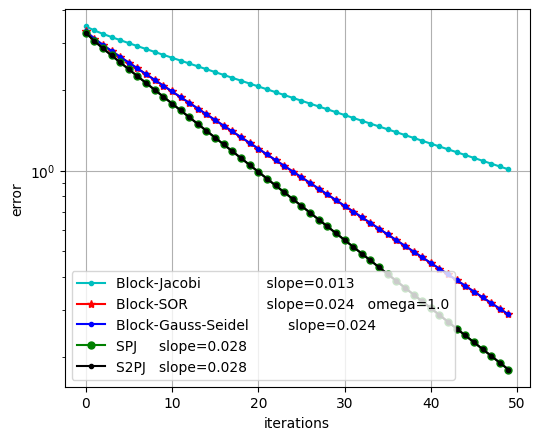

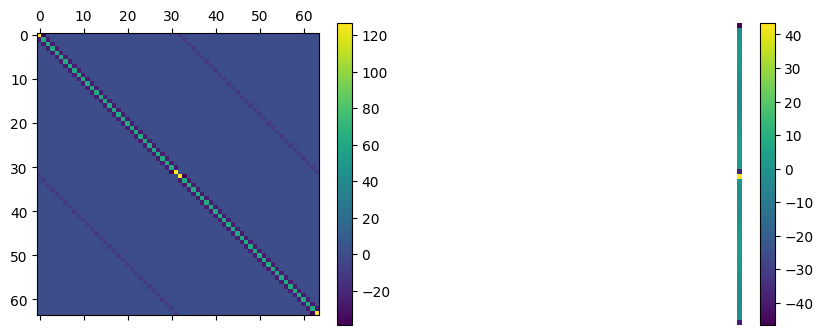

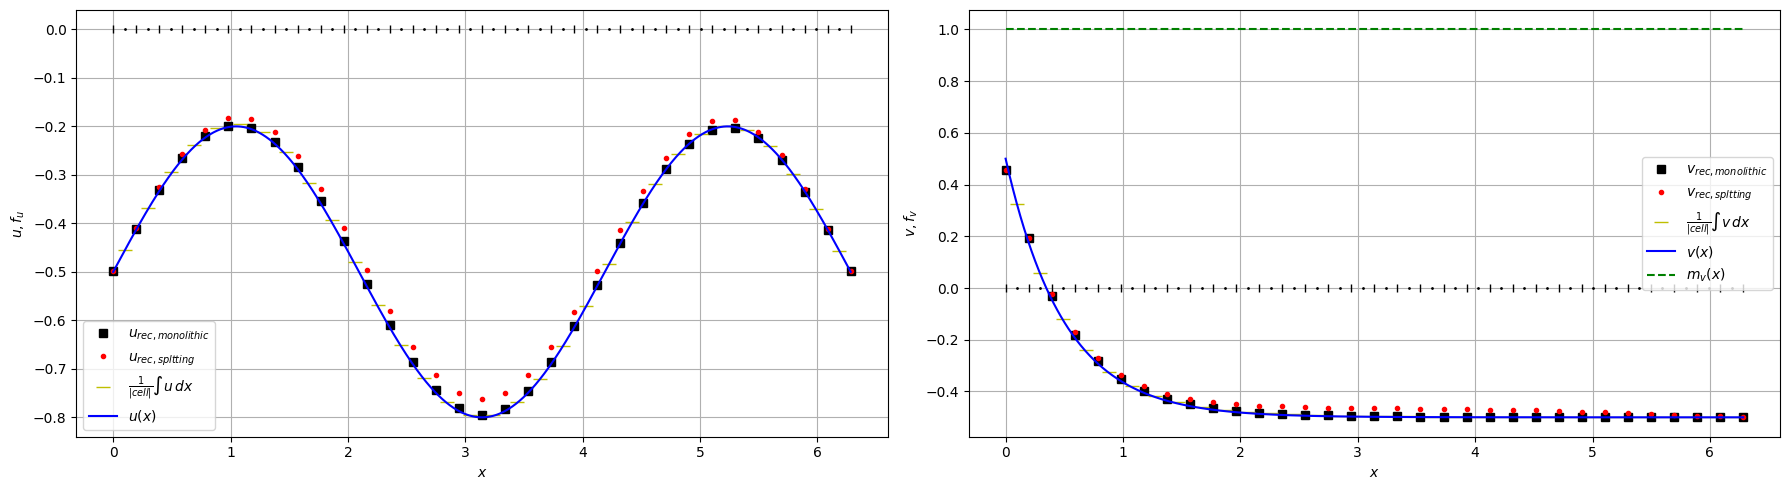

In [17]:
kwargs = {
    'beta': 10.0,

    'A': 1.0,
    'B': 0.2,
    'C': 1.0,

    'D': 1.0,
    'E': 0.0,
    'F': 1.0,
    'G': 0.0,

    'H': 1.0,
    'I': 0.0,
    'L': 2.0,
    'M': 0.0,

    'N': -0.5,
    'O': 0.3,
    'P': 1.5,
    'Q': 0.0,

    'R': -0.5,
    'S': 1.0,
    'T': 2.0
}

def u_sol(x, kwargs):
    return kwargs['N'] + kwargs['O']*np.sin(kwargs['P']*(x-kwargs['Q']))

def dudx_sol(x, kwargs):
    return kwargs['O']*kwargs['P']*np.cos(kwargs['P']*(x-kwargs['Q']))

def d2udx2_sol(x, kwargs):
    return -kwargs['O']*np.square(kwargs['P'])*np.sin(kwargs['P']*(x-kwargs['Q']))


def v_sol(x, kwargs):
    return kwargs['R'] + kwargs['S']*np.exp(-kwargs['T']*x)

def dvdx_sol(x, kwargs):
    return -kwargs['S']*kwargs['T']*np.exp(-kwargs['T']*x)

def d2vdx2_sol(x, kwargs):
    return kwargs['S']*np.square(kwargs['T'])*np.exp(-kwargs['T']*x)


def m_u(x, kwargs):
    return kwargs['D'] + kwargs['E']*np.sin(kwargs['F']*(x-kwargs['G']))

def dm_udx(x, kwargs):
    return kwargs['E']*kwargs['F']*np.cos(kwargs['F']*(x-kwargs['G']))


def m_v(x, kwargs):
    return kwargs['H'] + kwargs['I']*np.sin(kwargs['L']*(x-kwargs['M']))

def dm_vdx(x, kwargs):
    return kwargs['I']*kwargs['L']*np.cos(kwargs['L']*(x-kwargs['M']))


def f_1(x, kwargs):
    return kwargs['beta']*(u_sol(x, kwargs)-v_sol(x, kwargs)) - (dm_udx(x, kwargs)*dudx_sol(x, kwargs) + m_u(x, kwargs)*d2udx2_sol(x, kwargs))

def f_2(x, kwargs):
    return kwargs['beta']*(v_sol(x, kwargs)-u_sol(x, kwargs)) - (dm_vdx(x, kwargs)*dvdx_sol(x, kwargs) + m_v(x, kwargs)*d2vdx2_sol(x, kwargs))

L = 2.0*np.pi
N = 32
dx = np.divide(L, N)
x = np.linspace(0, L, N+1) #faces coordinates
xc = np.linspace(0.5*dx, L-0.5*dx, N) #centercells coordinates
xfine = np.linspace(0, L, 1000)

leftBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':u_sol(0.0, kwargs)}

rightBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':u_sol(L, kwargs)}

leftBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':v_sol(0.0, kwargs)}

rightBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':v_sol(L, kwargs)}

A_laplacian, f1BC = mylib.fvm_laplacian_1D(m_u, leftBC_u, rightBC_u, N, dx, L, kwargs)
A = kwargs['beta']*sparse.eye(N) - A_laplacian

B = -kwargs['beta']*sparse.eye(N)

C = -kwargs['beta']*sparse.eye(N)

D_laplacian, f2BC = mylib.fvm_laplacian_1D(m_v, leftBC_v, rightBC_v, N, dx, L, kwargs)
D = kwargs['beta']*sparse.eye(N) - D_laplacian

f1 = f_1(xc, kwargs) - f1BC
f2 = f_2(xc, kwargs) - f2BC

A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A
Z[:N,N:] = B
Z[N:,:N] = C
Z[N:,N:] = D

f = np.concatenate((f1,f2))

sol = linalg.solve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

omega = 1.0
nit = 50
u_BJ,   v_BJ,   res_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit, 0, sol)
u_BSOR, v_BSOR, res_BSOR = mylib.method_BlockSOR(             A, B, C, D, f1, f2, nit, omega, sol)
u_BGS,  v_BGS,  res_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit, 0, sol)
u_SPJ,  v_SPJ,  res_SPJ  = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit, 0, sol)
u_SPJ2, v_SPJ2, res_SPJ2 = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit, sol)

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")
print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)

################################################

plt.figure(dpi=100, figsize=(6,5))
nn = 5
plt.semilogy(res_BJ,  'c.-',  label=f"Block-Jacobi               slope={np.round(-mylib.slope(res_BJ[:nn]), 3)}")
plt.semilogy(res_BSOR, 'r*-', label=f"Block-SOR                  slope={np.round(-mylib.slope(res_BSOR[:nn]), 3)}   omega={omega}")
plt.semilogy(res_BGS, 'b.-',  label=f"Block-Gauss-Seidel         slope={np.round(-mylib.slope(res_BGS[:nn]), 3)}   ")
plt.semilogy(res_SPJ, 'g.-',  label=f"SPJ     slope={np.round(-mylib.slope(res_SPJ[:nn]), 3)}", markersize=10)
plt.semilogy(res_SPJ2,'k.-',  label=f"S2PJ   slope={np.round(-mylib.slope(res_SPJ2[:nn]), 3)}")
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
plt.savefig('figures/error1.pdf')

################################################

fig1, axs = plt.subplots(1, 2, figsize=(10,4), dpi=100)
axs0 = axs[0].matshow(Z)
#axs0 = axs[0].spy(Z)
axs1 = axs[1].matshow(f.reshape((2*N,1)))
fig1.colorbar(axs0, ax=axs[0])
fig1.colorbar(axs1, ax=axs[1])
axs[1].axis('off')
#plt.savefig('figures/matrix.pdf')

################################################

fig, ax = plt.subplots(1, 2, figsize=(18,5), dpi=100)
markersize = 10
linewidth = 0.8
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u,f_u$')
ax[0].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJ), '.r' , label=r'$u_{rec,spltting}$', linewidth=linewidth)
ax[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
ax[0].plot(xfine, u_sol(xfine, kwargs), '-b', label=r'$u(x)$')
#ax[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
#ax[0].plot(xfine, f_1(xfine, kwargs), '--c', label=r'$f_u(x)$')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$v,f_v$')
ax[1].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJ), '.r' , label=r'$v_{rec,spltting}$', linewidth=linewidth)
ax[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
ax[1].plot(xfine, v_sol(xfine, kwargs), '-b', label=r'$v(x)$')
ax[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
#ax[1].plot(xfine, f_2(xfine, kwargs), '--c', label=r'$f_v(x)$')
ax[1].legend()
ax[1].grid()

#ax[0].plot(x, mylib.fvm_reconstruct_1D(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax[0].plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax[0].set_ylim(bottom=-4, top=4)
#ax[1].set_ylim(bottom=-4, top=4)
#ax[0].set_xlim([-0.001,0.1])
plt.tight_layout()
plt.show()